# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

### Цель проекта   

<font color = brown>**Прогнозирование ухода клиента банка в ближайшее время**</font>

### План исследования:   
#### 1. Предобработка данных:   

- изучение общей информации методами .info(), .head();
- проверка корректности написания имен столбцов;
- проверка на наличие дубликатов. Удаление при необходимости;
- проверка признаков на пропущенные значения. Замена пропущенных значений;
- проверка и при необходимости замена типов данных столбцов;
- вывод по разделу.  

#### 2. Подготовка данных для обучения моделей:   

- удаление избыточных признаков;
- преобразование категориальных признаков в количественные методами One-Hot-Encoding, Ordinal Encoding;
- построение диаграм для визуальной оценки распределений признаков;
- вывод по разделу.  

#### 3. Исследование задачи:   

- разбивка исходного датасета на обучающую, проверочную и тестовую выборки;
- обучение модели "решающее дерево с разным значение гиперпараметра "глубина";
- обучение модели "лес деревьев" с разным значение гиперпараметра "кол.-во деревьев";
- обучение модели "логистическая регрессия" ;
- выбор итоговой модели из сравнения значений метрик f1 и auc-roc;
- вывод по разделу.  

#### 4. Борьба с дисбалансом классов:

- примнение метода upsampling;
- примнение метода downsampling;
- повторное обучение моделей на сбалансированных данных;
- вывод по разделу. 

#### 4. Проверка выбранной модели на тестовой выборке.   

#### 5. Общий вывод.

In [49]:
# Импорт необходимых библиотек

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

### 1. Предобработка данных

In [50]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


<font color = brown>По итогам изучения общей информации установлено:   
    
- необходимость обработки пропусков в признака Tenure;   
- имена столбцов указаны корректно;
- признаки не содержат дубликаты;
- типы признаков определны корректно.</font>

In [52]:
# Заполним пропуски в признаке Tenure нулями
data['Tenure'] = data['Tenure'].fillna(0.0)


Посчитал некорректным удалять данные с пропусками, из-за того, что датасет уж больно мал. Удаление почти 10% показалось слишком опасным.   
Нулями заполнил, потому что в прошедшую субботу так рекомендовал наставник в своем вебинаре. Изначально заполнял медианой. Логика заполенния нулями, насколько я понял, заключалась в том, что, что если признак пропущен, то скорее всего у клиента нет недвижимости. И самое главное, что график распределения становился более выроненным по краям.   
График ниже.   

К сожалению, не знаком методами вывода важностии факторов :( Не мог бы объяснить чуть подробнее на примере?

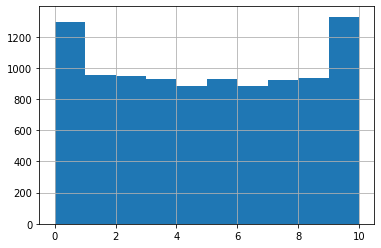

In [53]:
data['Tenure'].hist();

In [54]:
# Проверим на отсуствие пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [55]:
# Проверим дубликаты
data.duplicated().sum()

0

### 2. Подготовка данных для обучения моделей:  

In [56]:
# Удалим лишние избыточные неинформативные признаки
data.drop(['CustomerId', 'Surname', 'RowNumber'], axis = 1, inplace = True)

<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
ок)

In [57]:
# Посмотрим на наполнение признака 'Gender'
data['Gender'].value_counts()


Male      5457
Female    4543
Name: Gender, dtype: int64

In [58]:
# Преобразуем значения признака 'Gender' чиловые значения
data['Gender'] = data['Gender'].map({'Male' : 0, 'Female' : 1})

In [59]:
# Преобразуем методами One-Hot Encoding и Ordinal Encoding столбец 'Geography' 

# One-Hot Encoding
geo_ohe = pd.get_dummies(data['Geography'], drop_first = True)
geo_ohe = pd.DataFrame(geo_ohe, columns = geo_ohe.columns)
geo_ohe.head()

,Germany,Spain
0,0,0
1,0,1
2,0,0
3,0,0
4,0,1


In [60]:
# Ordinal Encoding

or_encoder = OrdinalEncoder()
geo_ord = or_encoder.fit_transform(data[['Geography']])
geo_ord = pd.DataFrame(geo_ord, columns = ['Geography'])
geo_ord.head()

,Geography
0,0.0
1,2.0
2,0.0
3,0.0
4,2.0


In [61]:
# Добавим преобразованные признаки в первичный датасет

data.loc[:, 'Geography'] = geo_ord.loc[:, 'Geography']
data = data.join(geo_ohe)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Germany,Spain
0,619,0.0,1,42,2.0,0.00,1,1,1,101348.88,1,0,0
1,608,2.0,1,41,1.0,83807.86,1,0,1,112542.58,0,0,1
2,502,0.0,1,42,8.0,159660.80,3,1,0,113931.57,1,0,0
3,699,0.0,1,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,2.0,1,43,2.0,125510.82,1,1,1,79084.10,0,0,1


In [62]:
# sns.pairplot(data);

<font color = brown>**В этом разделе произведена подготовка данных для дальнейшей работы с моделями.   
Были удалены избыточные признаки, преобразованы категориальные методами One-Hot Encoding, Ordinal Encoding.   
В зависимости от типа моделей, которые будут применяться в дальнейшем, буду удалять ненужные признаки, оставшиеся после кодировки ('Geography', 'France', 'Germany', 'Spain').**

**Визуализация гистаграмм и диаграмм рассеивания практически не дала никакой информации, кроме того, что классы целевого признака сильно разбалансированы**</font>

### 3. Исследование задачи

In [63]:
x = data.drop(['Exited'], axis = 1)
y = data['Exited']

In [64]:
# Разделяем выборку на обучающую, проверочную и тестовую

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.4, random_state = 12345)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size = 0.5, random_state = 12345)


In [65]:
x_train.shape, x_valid.shape, x_test.shape

((6000, 12), (2000, 12), (2000, 12))

In [66]:
# Дерево решений

for i in range (1, 40, 4):
    DecTree = DecisionTreeClassifier(random_state=12345, max_depth = i)
    DecTree.fit(x_train.drop(['Germany', 'Spain'], axis = 1), y_train)
    predictions = DecTree.predict(x_valid.drop(['Germany', 'Spain'], axis = 1))
    
    probabilities_valid = DecTree.predict_proba(x_valid.drop(['Germany', 'Spain'], axis = 1))
    probabilities_one_valid = probabilities_valid[:, 1]

    auc_roc = round(roc_auc_score(y_valid, probabilities_one_valid), 2)    
    
    print('max_depth = ', i, 'f1_score : ', round(f1_score(y_valid,predictions), 2), ', auc_roc : ', auc_roc)

max_depth =  1 f1_score :  0.0 , auc_roc :  0.69
max_depth =  5 f1_score :  0.52 , auc_roc :  0.82
max_depth =  9 f1_score :  0.53 , auc_roc :  0.76
max_depth =  13 f1_score :  0.49 , auc_roc :  0.68
max_depth =  17 f1_score :  0.46 , auc_roc :  0.66
max_depth =  21 f1_score :  0.46 , auc_roc :  0.66
max_depth =  25 f1_score :  0.46 , auc_roc :  0.66
max_depth =  29 f1_score :  0.46 , auc_roc :  0.66
max_depth =  33 f1_score :  0.46 , auc_roc :  0.66
max_depth =  37 f1_score :  0.46 , auc_roc :  0.66


In [67]:
# Случайный лес

for i in range(1, 150,10):
    RndForest = RandomForestClassifier(random_state=12345, n_estimators = i)
    RndForest.fit(x_train.drop(['Germany', 'Spain'], axis = 1), y_train)
    
    probabilities_valid = RndForest.predict_proba(x_valid.drop(['Germany', 'Spain'], axis = 1))
    probabilities_one_valid = probabilities_valid[:, 1]

    auc_roc = round(roc_auc_score(y_valid, probabilities_one_valid), 2)
    
    predictions = RndForest.predict(x_valid.drop(['Germany', 'Spain'], axis = 1))
    print('Кол. - во голосов: ', i, 'f1_score : ', round(f1_score(y_valid,predictions), 2), ', auc_roc : ', auc_roc)

Кол. - во голосов:  1 f1_score :  0.5 , auc_roc :  0.68
Кол. - во голосов:  11 f1_score :  0.55 , auc_roc :  0.81
Кол. - во голосов:  21 f1_score :  0.56 , auc_roc :  0.82
Кол. - во голосов:  31 f1_score :  0.56 , auc_roc :  0.82
Кол. - во голосов:  41 f1_score :  0.56 , auc_roc :  0.83
Кол. - во голосов:  51 f1_score :  0.56 , auc_roc :  0.83
Кол. - во голосов:  61 f1_score :  0.56 , auc_roc :  0.83
Кол. - во голосов:  71 f1_score :  0.56 , auc_roc :  0.83
Кол. - во голосов:  81 f1_score :  0.57 , auc_roc :  0.83
Кол. - во голосов:  91 f1_score :  0.56 , auc_roc :  0.83
Кол. - во голосов:  101 f1_score :  0.57 , auc_roc :  0.83
Кол. - во голосов:  111 f1_score :  0.57 , auc_roc :  0.83
Кол. - во голосов:  121 f1_score :  0.56 , auc_roc :  0.83
Кол. - во голосов:  131 f1_score :  0.56 , auc_roc :  0.83
Кол. - во голосов:  141 f1_score :  0.56 , auc_roc :  0.84


In [68]:
# Логистическая регрессия

LogReg = LogisticRegression(random_state=12345, solver='liblinear')
LogReg.fit(x_train.drop(['Geography'], axis = 1) , y_train)
predictions = LogReg.predict(x_valid.drop(['Geography'], axis = 1))

probabilities_valid = LogReg.predict_proba(x_valid.drop(['Geography'], axis = 1))
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = round(roc_auc_score(y_valid, probabilities_one_valid), 2)

print('f1_score : ', round(f1_score(y_valid,predictions), 2), ', auc_roc : ', auc_roc)

f1_score :  0.08 , auc_roc :  0.67


Исправил. Как написал в предыдущем комментарии, не забыл, а не понял суть.   
Спасибо, Николай!

<font color = brown>**По итогам обучения разных моделей с перебором гиперпараметров лучшие результаты на совокупнсти метрик f1 и auc-roc показала модель "Случайный лес" с параметром n_estimators равным 100**</font>

### 3. Борьба с дисбалансом

In [117]:
# Посчитаем отношение в значениях между целевыми классами

ex_0_index = data[data['Exited'] == 0].index
ex_1_index = data[data['Exited'] == 1].index

repeat = int(round(ex_0.shape[0] / ex_1.shape[0],0))
repeat

4

In [119]:
# Создаем функции для балансировки.

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled


def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [120]:
# Создаем датасет upsampling
x_ups, y_ups = upsample(x_train, y_train, repeat)
x_ups.shape, y_ups.shape


((9588, 12), (9588,))

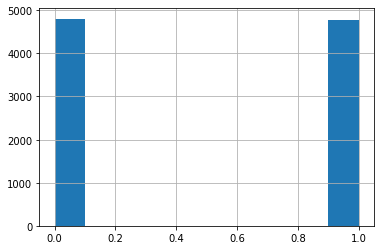

In [121]:
# Проверяем результат
y_ups.hist();

In [123]:
# Создаем датасет downsampling
x_dws, y_dws = downsample(x_train, y_train, 1 / repeat)
x_dws.shape, y_dws.shape

((2397, 12), (2397,))

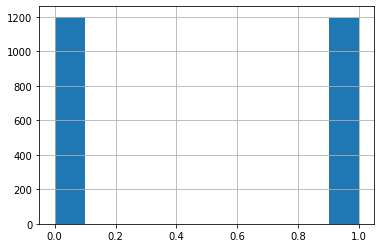

In [124]:
# Проверяем результат
y_dws.hist();

### 3.4. Обучение моделей

#### Upsampling

In [131]:
# Дерево решений

for i in range (1, 40, 4):
    DecTree_upsampling = DecisionTreeClassifier(random_state=12345, max_depth = i)
    DecTree_upsampling.fit(x_ups.drop(['Germany', 'Spain'], axis = 1), y_ups)
    
    predictions = DecTree_upsampling.predict(x_valid.drop(['Germany', 'Spain'], axis = 1))
    
    probabilities_valid = DecTree_upsampling.predict_proba(x_valid.drop(['Germany', 'Spain'], axis = 1))
    probabilities_one_valid = probabilities_valid[:, 1]

    auc_roc = round(roc_auc_score(y_valid, probabilities_one_valid), 2)    
    
    print('max_depth = ', i, 'f1_score : ', round(f1_score(y_valid,predictions), 2), ', auc_roc : ', auc_roc)

max_depth =  1 f1_score :  0.5 , auc_roc :  0.69
max_depth =  5 f1_score :  0.59 , auc_roc :  0.82
max_depth =  9 f1_score :  0.53 , auc_roc :  0.76
max_depth =  13 f1_score :  0.48 , auc_roc :  0.69
max_depth =  17 f1_score :  0.47 , auc_roc :  0.67
max_depth =  21 f1_score :  0.47 , auc_roc :  0.67
max_depth =  25 f1_score :  0.47 , auc_roc :  0.67
max_depth =  29 f1_score :  0.47 , auc_roc :  0.67
max_depth =  33 f1_score :  0.47 , auc_roc :  0.67
max_depth =  37 f1_score :  0.47 , auc_roc :  0.67


In [132]:
# Случайный лес

for i in range(1, 150,10):
    RndForest_ups = RandomForestClassifier(random_state=12345, n_estimators = i)
    RndForest_ups.fit(x_ups.drop(['Germany', 'Spain'], axis = 1), y_ups)
    
    predictions = RndForest_ups.predict(x_valid.drop(['Germany', 'Spain'], axis = 1))    
    
    probabilities_valid = RndForest_ups.predict_proba(x_valid.drop(['Germany', 'Spain'], axis = 1))
    probabilities_one_valid = probabilities_valid[:, 1]

    auc_roc = round(roc_auc_score(y_valid, probabilities_one_valid), 2)
    

    print('Кол. - во голосов: ', i, 'f1_score : ', round(f1_score(y_valid,predictions), 2), ', auc_roc : ', auc_roc)

Кол. - во голосов:  1 f1_score :  0.49 , auc_roc :  0.68
Кол. - во голосов:  11 f1_score :  0.56 , auc_roc :  0.81
Кол. - во голосов:  21 f1_score :  0.58 , auc_roc :  0.82
Кол. - во голосов:  31 f1_score :  0.57 , auc_roc :  0.83
Кол. - во голосов:  41 f1_score :  0.59 , auc_roc :  0.83
Кол. - во голосов:  51 f1_score :  0.59 , auc_roc :  0.83
Кол. - во голосов:  61 f1_score :  0.6 , auc_roc :  0.84
Кол. - во голосов:  71 f1_score :  0.6 , auc_roc :  0.84
Кол. - во голосов:  81 f1_score :  0.6 , auc_roc :  0.84
Кол. - во голосов:  91 f1_score :  0.6 , auc_roc :  0.84
Кол. - во голосов:  101 f1_score :  0.6 , auc_roc :  0.84
Кол. - во голосов:  111 f1_score :  0.59 , auc_roc :  0.84
Кол. - во голосов:  121 f1_score :  0.6 , auc_roc :  0.84
Кол. - во голосов:  131 f1_score :  0.6 , auc_roc :  0.84
Кол. - во голосов:  141 f1_score :  0.6 , auc_roc :  0.84


In [133]:
# Логистическая регрессия

LogReg_ups = LogisticRegression(random_state=12345, solver='liblinear')
LogReg_ups.fit(x_ups.drop(['Geography'], axis = 1) , y_ups)

predictions = LogReg_ups.predict(x_valid.drop(['Geography'], axis = 1))

probabilities_valid = LogReg_ups.predict_proba(x_valid.drop(['Geography'], axis = 1))
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = round(roc_auc_score(y_valid, probabilities_one_valid), 2)

print('f1_score : ', round(f1_score(y_valid,predictions), 2), ', auc_roc : ', auc_roc)

f1_score :  0.45 , auc_roc :  0.72


#### Downsampling

In [134]:
# Дерево решений

for i in range (1, 40, 4):
    DecTree_downsampling = DecisionTreeClassifier(random_state=12345, max_depth = i)
    DecTree_downsampling.fit(x_dws.drop(['Germany', 'Spain'], axis = 1), y_dws)
    
    predictions = DecTree_downsampling.predict(x_valid.drop(['Germany', 'Spain'], axis = 1))
    
    probabilities_valid = DecTree_downsampling.predict_proba(x_valid.drop(['Germany', 'Spain'], axis = 1))
    probabilities_one_valid = probabilities_valid[:, 1]

    auc_roc = round(roc_auc_score(y_valid, probabilities_one_valid), 2)    
    
    print('max_depth = ', i, 'f1_score : ', round(f1_score(y_valid,predictions), 2), ', auc_roc : ', auc_roc)

max_depth =  1 f1_score :  0.51 , auc_roc :  0.7
max_depth =  5 f1_score :  0.54 , auc_roc :  0.81
max_depth =  9 f1_score :  0.52 , auc_roc :  0.76
max_depth =  13 f1_score :  0.51 , auc_roc :  0.72
max_depth =  17 f1_score :  0.49 , auc_roc :  0.71
max_depth =  21 f1_score :  0.49 , auc_roc :  0.7
max_depth =  25 f1_score :  0.49 , auc_roc :  0.7
max_depth =  29 f1_score :  0.49 , auc_roc :  0.7
max_depth =  33 f1_score :  0.49 , auc_roc :  0.7
max_depth =  37 f1_score :  0.49 , auc_roc :  0.7


In [135]:
# Случайный лес

for i in range(1, 150,10):
    RndForest_dws = RandomForestClassifier(random_state=12345, n_estimators = i)
    RndForest_dws.fit(x_dws.drop(['Germany', 'Spain'], axis = 1), y_dws)
    
    probabilities_valid = RndForest_dws.predict_proba(x_valid.drop(['Germany', 'Spain'], axis = 1))
    probabilities_one_valid = probabilities_valid[:, 1]

    auc_roc = round(roc_auc_score(y_valid, probabilities_one_valid), 2)
    
    predictions = RndForest_dws.predict(x_valid.drop(['Germany', 'Spain'], axis = 1))
    print('Кол. - во голосов: ', i, 'f1_score : ', round(f1_score(y_valid,predictions), 2), ', auc_roc : ', auc_roc)

Кол. - во голосов:  1 f1_score :  0.46 , auc_roc :  0.67
Кол. - во голосов:  11 f1_score :  0.55 , auc_roc :  0.82
Кол. - во голосов:  21 f1_score :  0.56 , auc_roc :  0.83
Кол. - во голосов:  31 f1_score :  0.58 , auc_roc :  0.84
Кол. - во голосов:  41 f1_score :  0.58 , auc_roc :  0.84
Кол. - во голосов:  51 f1_score :  0.58 , auc_roc :  0.84
Кол. - во голосов:  61 f1_score :  0.58 , auc_roc :  0.84
Кол. - во голосов:  71 f1_score :  0.57 , auc_roc :  0.84
Кол. - во голосов:  81 f1_score :  0.57 , auc_roc :  0.84
Кол. - во голосов:  91 f1_score :  0.57 , auc_roc :  0.84
Кол. - во голосов:  101 f1_score :  0.57 , auc_roc :  0.84
Кол. - во голосов:  111 f1_score :  0.58 , auc_roc :  0.84
Кол. - во голосов:  121 f1_score :  0.58 , auc_roc :  0.84
Кол. - во голосов:  131 f1_score :  0.58 , auc_roc :  0.84
Кол. - во голосов:  141 f1_score :  0.57 , auc_roc :  0.84


In [137]:
# Логистическая регрессия

LogReg_dws = LogisticRegression(random_state=12345, solver='liblinear')
LogReg_dws.fit(x_dws.drop(['Geography'], axis = 1) , y_dws)
predictions = LogReg_dws.predict(x_valid.drop(['Geography'], axis = 1))

probabilities_valid = LogReg_dws.predict_proba(x_valid.drop(['Geography'], axis = 1))
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = round(roc_auc_score(y_valid, probabilities_one_valid), 2)

print('f1_score : ', round(f1_score(y_valid,predictions), 2), ', auc_roc : ', auc_roc)

f1_score :  0.45 , auc_roc :  0.72


<font color = brown>**После балансировки классов целевого признака, ключевые метрики f1_score и auc_roc выросли по сравнению с обучением моделей на датасете с несбалансированнм целевым признаком, при этом результаты в методе upsampling выше, чем в методе downsampling.**   

**Как и в предыдущем случае наилучшие результаты показала модель "Случайный лес".**</font>

### 4. Тестирование модели

In [168]:
# UpSampling

end_model = RandomForestClassifier(random_state = 12345, n_estimators = 100)
# end_model.fit(feat_upsampling_data.drop(['Germany', 'Spain'], axis = 1), goal_upsampling_data)
end_model.fit(x_ups.drop(['Germany', 'Spain'], axis = 1), y_ups)


probabilities_valid = end_model.predict_proba(x_test.drop(['Germany', 'Spain'], axis = 1))
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = round(roc_auc_score(y_test, probabilities_one_valid), 2)

predictions = end_model.predict(x_test.drop(['Germany', 'Spain'], axis = 1))
print('f1_score : ', round(f1_score(y_test, predictions), 2), ', auc_roc : ', auc_roc)

f1_score :  0.59 , auc_roc :  0.85


In [169]:
# DownSampling

end_model = RandomForestClassifier(random_state = 12345, n_estimators = 100)
end_model.fit(x_dws.drop(['Germany', 'Spain'], axis = 1), y_dws)
# end_model.fit(x_test.drop(['Germany', 'Spain'], axis = 1), y_test)


probabilities_valid = end_model.predict_proba(x_test.drop(['Germany', 'Spain'], axis = 1))
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = round(roc_auc_score(y_test, probabilities_one_valid), 2)

predictions = end_model.predict(x_test.drop(['Germany', 'Spain'], axis = 1))
print('f1_score : ', round(f1_score(y_test, predictions), 2), ', auc_roc : ', auc_roc)

f1_score :  0.56 , auc_roc :  0.84


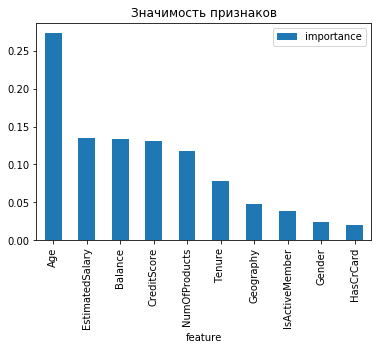

In [156]:
# Определяем значимость признаков
ddd = pd.DataFrame({'feature': list(x_test.drop(['Germany', 'Spain'], axis = 1).columns),
                   'importance': end_model.feature_importances_}).\
                    sort_values('importance', ascending = False).plot(kind='bar', x='feature')
plt.title('Значимость признаков');

## Вывод

<font color = brown>**По итогам выполненного проекта была получена модель с заданным по условию задачи значением метрики f1.**   
**Значение указанной выше метрики, а также высокое знаечние метрики auc-roc, было достигнуто благодаря проведенной борьбе с дисбалансом классов целевого признака различными методами.**</font>
